In [15]:
using Gen, Plots, LinearAlgebra


In [1]:
# println("Hello World")

# function init_ball()

# function simulate(ball_p0, ball_v0, walls, object, number_of_time steps, distribution of jitter)
#     # ie: init ball params, environment params, simulation params
    
    
#     first_hit = hit(ball_p0, ball_v0, walls, object)
#     return list_of ball positions (maybe without the_ones under the_occluder)


In [20]:
function collide(position, entity)
    # Check if the position is inside the entity
    return (position[1] >= entity[1][1] && position[1] <= entity[2][1] &&
            position[2] >= entity[1][2] && position[2] <= entity[2][2])
end


collide (generic function with 2 methods)

In [37]:
@gen function simulate_ball_model_collision_jitter_sparse(ball_p0, ball_v0, walls, object, num_steps, jitter_std)
    ball_positions = Vector{Vector{Float64}}(undef, num_steps)

    ball_p = copy(ball_p0)  # Ensure ball_p is a copy to avoid modifying the original ball_p0
    ball_v = ball_v0

    collided = false  # Flag to track whether a collision has occurred

    for step in 1:num_steps
        # Exit the loop if a collision has occurred
        if collided
            break
        end

        # Simulate ball movement
        ball_p += ball_v

        # Check for collisions with walls
        for wall in walls
            if collide(ball_p, wall)
                ball_v = reflect(ball_v, wall)
                ball_p[1] += randn() * jitter_std  # Add jitter to the x-coordinate
                ball_p[2] += randn() * jitter_std  # Add jitter to the y-coordinate
            end
        end

        # Check for collisions with the object
        if collide(ball_p, object)
            normal = normalize(object[2] - object[1])
            ball_v = reflect(ball_v, (object[1], object[2], normal))
            ball_p[1] += randn() * jitter_std  # Add jitter to the x-coordinate
            ball_p[2] += randn() * jitter_std  # Add jitter to the y-coordinate

            collided = true  # Set the flag to indicate a collision
        end

        # Add jitter to the current position in the ground truth trajectory
        ball_p[1] += randn() * jitter_std
        ball_p[2] += randn() * jitter_std

        ball_positions[step] = copy(ball_p)
    end

    return ball_positions
end


DynamicDSLFunction{Any}(Dict{Symbol,Any}(), Dict{Symbol,Any}(), Type[Any, Any, Any, Any, Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing, nothing, nothing, nothing], ##simulate_ball_model_collision_jitter_sparse#276, Bool[0, 0, 0, 0, 0, 0], false)

In [38]:


function is_inside_room(position, walls, object)
    # Check if the position is inside the room (within walls and object)
    return all(collide(position, wall) for wall in walls) && collide(position, object)
end

function reflect(v, wall)
    # Reflect the vector v based on the collision with the wall
    normal = normalize(wall[2] - wall[1])
    dot_product = dot(v, normal)
    return v - 2 * dot_product * normal
end

reflect (generic function with 1 method)

In [39]:
function simulate_and_plot_collision(ball_p0, ball_v0, walls, object, num_steps, jitter_std)
    model = simulate_ball_model_collision
    (trace, _) = generate(model, (ball_p0, ball_v0, walls, object, num_steps, jitter_std))

    ball_positions = get_retval(trace)

    plot_trajectory(ball_positions, walls, object)
end

function plot_trajectory(ball_positions, walls, object)
    p = plot()

    # Plot walls as a square
    plot!([0, 10, 10, 0, 0], [0, 0, 10, 10, 0], color=:black, linewidth=2, label="Walls")

    # Center of the room (within the walls)
    center_x = 5.0
    center_y = 5.0

    # Plot object as a square centered at (5,5)
    object_width = min(10, object[2][1] - object[1][1])
    object_height = min(10, object[2][2] - object[1][2])

    plot!([center_x - object_width / 2, center_x + object_width / 2, center_x + object_width / 2, center_x - object_width / 2, center_x - object_width / 2],
          [center_y - object_height / 2, center_y - object_height / 2, center_y + object_height / 2, center_y + object_height / 2, center_y - object_height / 2],
          color=:red, linewidth=2, linestyle=:solid, label="Object")

    # Plot ball trajectory
    plot!(map(p -> p[1], ball_positions), map(p -> p[2], ball_positions),
          marker=:circle, markersize=5, label="Ball")

    display(p)
end

plot_trajectory (generic function with 1 method)

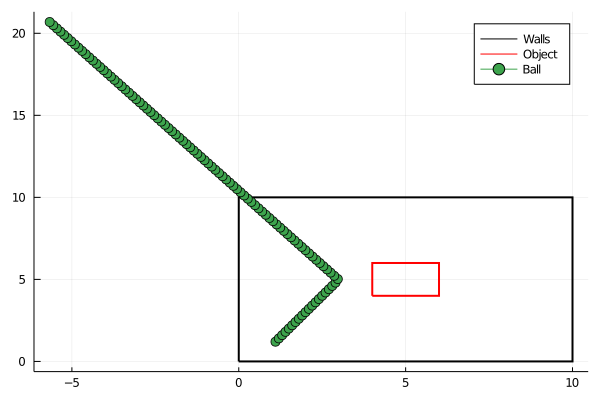

In [47]:
# Example usage
ball_p0 = [1.0, 1.0]
ball_v0 = [0.1, 0.2]
walls = [([0.0, 0.0], [5.0, 0.1]), ([0.0, 0.0], [0.1, 5.0]),
         ([5.0, 0.0], [5.1, 5.0]), ([0.0, 5.0], [5.0, 5.1])]
object = ([-1.0, -1.0], [1.0, 1.0])
num_steps = 100
jitter_std = 0.1  # Set the standard deviation for jitter

simulate_and_plot_collision(ball_p0, ball_v0, walls, object, num_steps, jitter_std)